In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from skimage.io import imshow
#from sklearn.model_selection import train_test_split

#import tensorflow as tf

import keras

from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
#making sure GPU is in use 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6372450589116341553
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11285289370
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6864352473004466330
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
# Set some parameters
in_height = 64
in_width = 64
out_height = 256
out_width = 256
color_dim = 3
path_in = '/home/Matthew/image-super-resolution/data/imagenet/10k/res64/'
path_out = '/home/Matthew/image-super-resolution/data/imagenet/10k/res256/'

In [4]:
#todo: add random shuffle 
#, seed = 0

def load_images(path_in, path_out, test_size):
    images = next(os.walk(path_in))[2] #oswalk is a generator 
    num_images = len(images)

    splitIdx = int(test_size * num_images)
    testSize = int((test_size) * num_images)
    trainSize = int(math.ceil((1-test_size) * num_images))
    
    X_train = np.zeros((trainSize,in_height,in_width,color_dim), dtype=np.float32)
    X_test = np.zeros((testSize,in_height,in_width,color_dim), dtype=np.float32)
    y_train = np.zeros((trainSize,out_height,out_width,color_dim), dtype=np.float32)
    y_test  = np.zeros((testSize,out_height,out_width,color_dim), dtype=np.float32)

    trainIdx = 0
    testIdx = 0
    for idx, image in enumerate(images):
        image_in_path = os.path.join(path_in,image)
        image_out_path = os.path.join(path_out,image)

        image_in_raw =  load_img(image_in_path, grayscale=False)
        image_out_raw = load_img(image_out_path, grayscale=False)

        #converts image to keras preprocessing image, then divide by 255 to un-invert the images
        image_in = (img_to_array(image_in_raw)).squeeze() / 255 
        image_out = (img_to_array(image_out_raw)).squeeze() / 255          
 
        try:
            if (idx % 1000 == 0):
                print("Stage " + str(idx))
        
            if (idx >= splitIdx):
                #print("trainIdx " + str(trainIdx))
                X_train[trainIdx] = image_in
                y_train[trainIdx] = image_out
                
                trainIdx+=1
            else:
                #print("testIdx " + str(testIdx))
                X_test[testIdx] = image_in
                y_test[testIdx] = image_out
                
                testIdx+=1
                
        except Exception as e: 
            print("\nERROR!!!!")
            print(image_in.shape)
            print(trainIdx)
            
            print(image_out.shape)
            print(testIdx)
            
            print("id "+str(idx))
            print(image_in_path)
            print(e)
           
            print("\n")
            
    return X_train,X_test,y_train,y_test

In [5]:
X_train,X_test,y_train,y_test = load_images(path_in, path_out, .2)

Stage 0
Stage 1000
Stage 2000
Stage 3000
Stage 4000
Stage 5000
Stage 6000
Stage 7000
Stage 8000
Stage 9000


In [6]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D
from keras.optimizers import RMSprop

In [7]:
#https://github.com/zeoya/Keras-Super-Resolution/blob/master/myUtils/srcnn.py

In [8]:
#padding output size: see http://cs231n.github.io/convolutional-networks/
# output = (W−F+2P)/S+1   w- input size, f-kernel size, p-padding size 

In [10]:
model = Sequential()
inputShape = (in_height, in_width, color_dim)
model.add(UpSampling2D((4,4),input_shape=inputShape))
#model.add(Conv2D(64, (9, 9), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 64
model.add(Activation("relu"))
model.add(Conv2D(32, (9, 9), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 32
model.add(Activation("relu"))
model.add(Conv2D(color_dim, (5, 5), padding='same', kernel_initializer="he_normal")) # 256 X 256 X 3
model.add(Activation("sigmoid"))

In [11]:
model.compile(loss='mean_squared_error', optimizer = RMSprop())

In [12]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 256, 256, 3)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      7808      
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 3)       2403      
_________________________________________________________________
activation_3 (Activation)    (None, 256, 256, 3)       0         
Total params: 10,211
Trainable params: 10,211
Non-trainable params: 0
_________________________________________________________________


In [13]:
batch_size = 256
epochs = 40

trainHistory = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

Train on 8000 samples, validate on 2000 samples
Epoch 1/40
8000/8000 [==============================] - 86s 11ms/step - loss: 0.0624 - val_loss: 0.0686
Epoch 2/40
8000/8000 [==============================] - 65s 8ms/step - loss: 0.0441 - val_loss: 0.0331
Epoch 3/40
8000/8000 [==============================] - 65s 8ms/step - loss: 0.0325 - val_loss: 0.0232
Epoch 4/40
8000/8000 [==============================] - 65s 8ms/step - loss: 0.0257 - val_loss: 0.0164
Epoch 5/40
8000/8000 [==============================] - 65s 8ms/step - loss: 0.0226 - val_loss: 0.0226
Epoch 6/40
8000/8000 [==============================] - 65s 8ms/step - loss: 0.0183 - val_loss: 0.0146
Epoch 7/40
8000/8000 [==============================] - 65s 8ms/step - loss: 0.0170 - val_loss: 0.0155
Epoch 8/40
8000/8000 [==============================] - 65s 8ms/step - loss: 0.0166 - val_loss: 0.0141
Epoch 9/40
8000/8000 [==============================] - 65s 8ms/step - loss: 0.0157 - val_loss: 0.0117
Epoch 10/40
8000/8000 [=

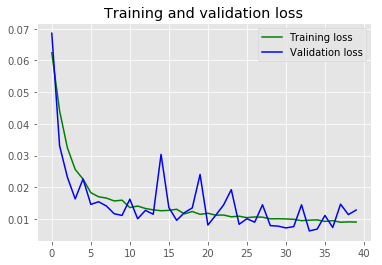

In [14]:
loss = trainHistory.history['loss']
val_loss = trainHistory.history['val_loss']
epochsRange = range(epochs)
plt.figure()
plt.plot(epochsRange, loss, label='Training loss',color='g')
plt.plot(epochsRange, val_loss, label='Validation loss',color='b')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
pred = model.predict(X_test)

Test Images


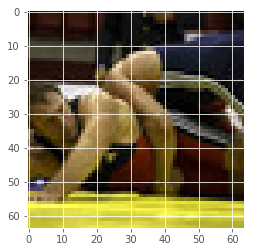

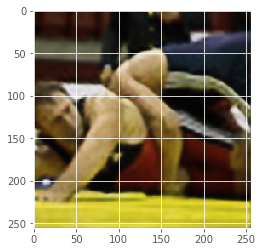

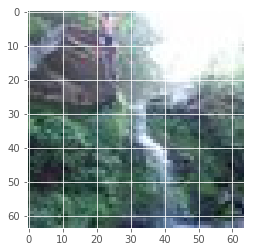

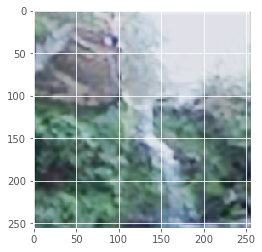

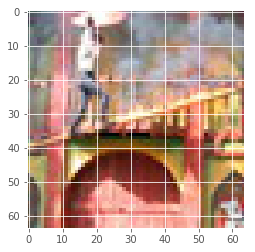

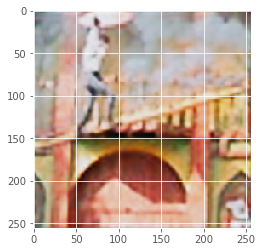

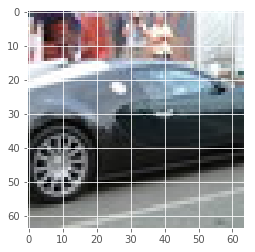

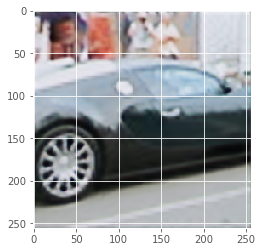

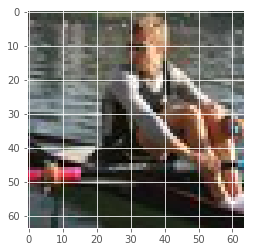

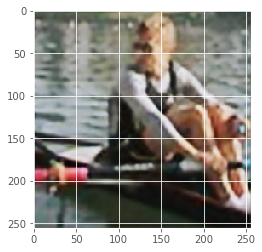

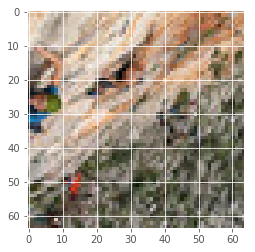

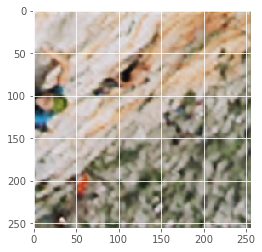

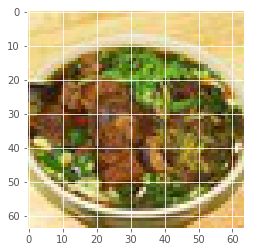

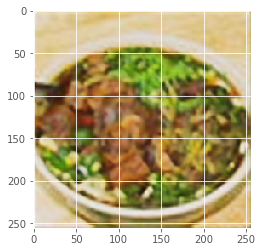

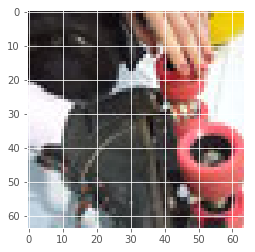

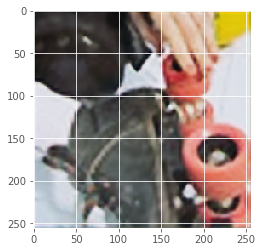

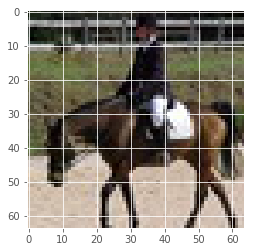

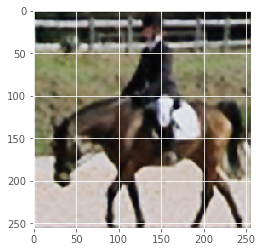

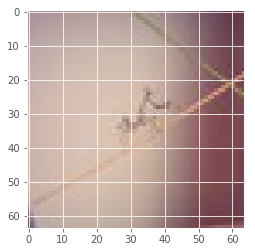

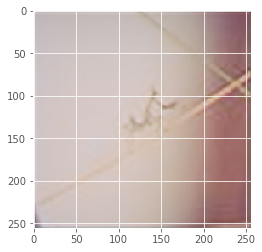

In [16]:
#plt.figure(figsize=(256, 256))
print("Test Images")

for i in range(10):
    #plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i])
    plt.show()
    plt.imshow(pred[i])
    #curr_lbl = y_test[i]
    #plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
    plt.show()
#plt.figure(figsize=(256, 256))
#print("Reconstruction of Test Images")
#for i in range(10):
    #plt.subplot(2, 10, i+1)
    #plt.imshow(pred[i])  
    #plt.show()

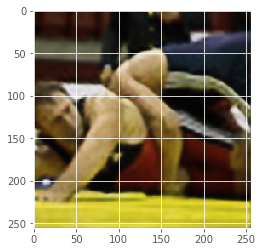

In [17]:
plt.imshow(pred[0])  